# Importing data and important libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train_data = pd.read_csv('train.csv')
# Creating train_df that will be used to be the final dataframe after all the modifications
train_df = train_data.copy()

# Exploring the data

<Axes: xlabel='Sex', ylabel='count'>

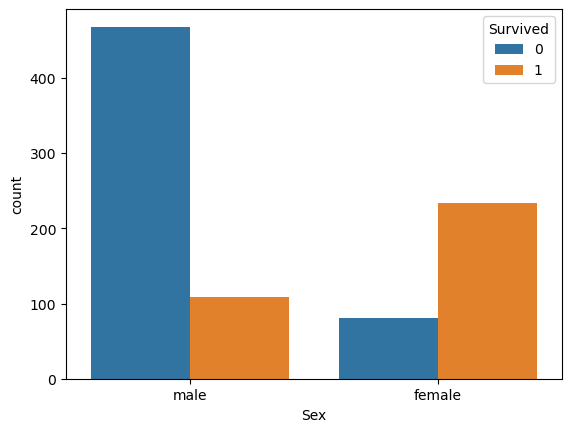

In [3]:
sns.countplot(data=train_data,x='Sex',hue='Survived')

<Axes: xlabel='Pclass', ylabel='count'>

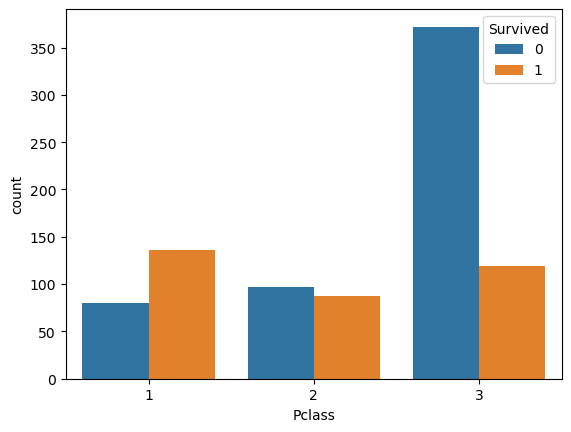

In [7]:
sns.countplot(data=train_data,x='Pclass',hue='Survived')

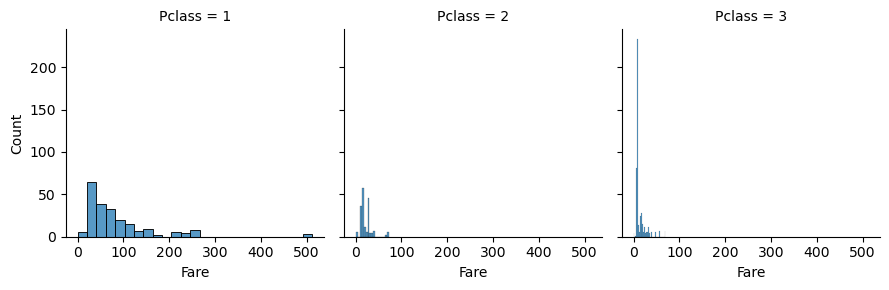

In [4]:
sns.FacetGrid(data=train_data, col='Pclass').map(sns.histplot, 'Fare')

<Axes: xlabel='Age', ylabel='Count'>

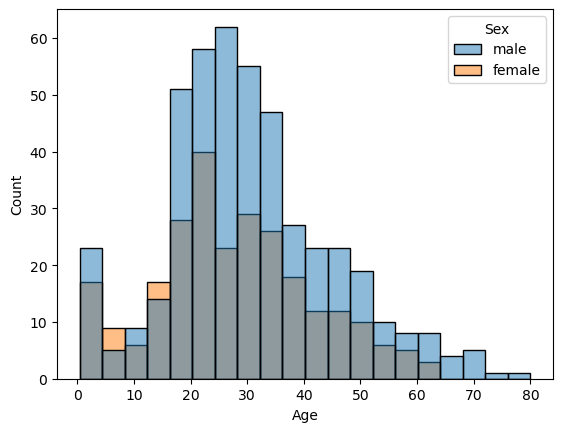

In [5]:
sns.histplot(data=train_data, x='Age', hue='Sex')

# Cleaning the data

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We have 177 null values in the Age column, which seems to be an important feature. In order to not lose the data, I'm going to fill those null values with the median Age per Sex per Class.

In [8]:
train_data.groupby(['Sex', 'Pclass'])['Age'].agg(['min', 'max', 'mean', 'median', 'std'])

min   max       mean  median        std
Sex    Pclass                                          
female 1       2.00  63.0  34.611765    35.0  13.612052
       2       2.00  57.0  28.722973    28.0  12.872702
       3       0.75  63.0  21.750000    21.5  12.729964
male   1       0.92  80.0  41.281386    40.0  15.139570
       2       0.67  70.0  30.740707    30.0  14.793894
       3       0.42  74.0  26.507589    25.0  12.159514

In [9]:
# Calculates the median Age per Sex and per Pclass
median_ages_per_sex = train_data.groupby(['Sex', 'Pclass'])['Age'].median()

# Substitute null values for the median Age per Sex per Pclass
train_df['Age'] = train_df.apply(
                lambda row: round(median_ages_per_sex[row['Sex']][row['Pclass']])
                  if pd.isnull(row['Age']) else row['Age'], axis=1)

The Cabin column has too many null values, so for now I'm going to drop that column. By doing that, the only column that is left with null values is the column "Embarked". Considering it has only 2 null values, I'm going to drop those rows, resulting in a final dataset of 889 rows with no blank values.

In [70]:
train_df = train_df.drop('Cabin', axis=1).dropna()

In [71]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


# Converting the categorical variables into dummy/indicators variables

In [73]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

In [74]:
cat_columns = ['Sex', 'Embarked']

In [82]:
train_df = pd.get_dummies(train_df, columns=cat_columns, drop_first=True)

In [83]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex_male,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,True,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,False,False,False
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,False,False,True
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,True,False,True


# Training and validating previous results

In [87]:
# features
X=train_df.drop(['PassengerId', 'Survived', 'Name', 'Ticket'], axis=1)

# target
y=train_df['Survived']

In [90]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [92]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=1)

In [93]:
pred = rfc.predict(X_test)

In [95]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, pred))
print(' ')
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       184
           1       0.84      0.66      0.74       110

    accuracy                           0.83       294
   macro avg       0.83      0.79      0.81       294
weighted avg       0.83      0.83      0.82       294

 
[[170  14]
 [ 37  73]]


# Training full data and generating the results

Cleaning test base

In [132]:
# Importing test data
test_data = pd.read_csv('test.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [133]:
# Calculates the median Age per Sex and per Pclass
median_ages_per_sex = test_data.groupby(['Sex', 'Pclass'])['Age'].median()

# Calculate mean fare
test_data['Fare'].mean()

# Substitute null values for the median Age per Sex per Pclass
test_data['Age'] = test_data.apply(
                lambda row: round(median_ages_per_sex[row['Sex']][row['Pclass']])
                  if pd.isnull(row['Age']) else row['Age'], axis=1)

test_data['Fare'] = test_data.apply(lambda row: 35.6 if pd.isnull(row['Fare']) else row['Fare'], axis=1)

In [134]:
test_data = test_data.drop('Cabin', axis=1)

In [135]:
X_test = pd.get_dummies(test_data.drop(['PassengerId', 'Name', 'Ticket'],axis=1), columns=cat_columns,drop_first=True)
X_test = X_test.dropna()

Training model and generating final results

In [136]:
rfc.fit(X, y)

RandomForestClassifier(max_depth=5, random_state=1)

In [137]:
predictions = rfc.predict(X_test)

In [138]:
predictions

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [139]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)